In [1]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import BertForTokenClassification, AdamW

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
train = pd.read_csv("data/train.csv", sep=",", encoding="latin1")
val = pd.read_csv("data/val.csv", sep=",", encoding="latin1")
test = pd.read_csv("data/test.csv", sep=",", encoding="latin1")
data = pd.read_csv("data/ner_dataset.csv", sep=",", encoding="latin1").fillna(method="ffill")

In [3]:
train.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,Italian,B-gpe
1,1,Sentence: 1,police,O
2,2,Sentence: 1,led,O
3,3,Sentence: 1,the,O
4,4,Sentence: 1,operation,O


In [4]:
val.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,The,O
1,1,Sentence: 1,Kurdish,O
2,2,Sentence: 1,party,O
3,3,Sentence: 1,has,O
4,4,Sentence: 1,fought,O


In [5]:
test.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,The,O
1,1,Sentence: 1,report,O
2,2,Sentence: 1,calls,O
3,3,Sentence: 1,on,O
4,4,Sentence: 1,President,B-per


In [6]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [8]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
train_getter = SentenceGetter(train)
val_getter = SentenceGetter(val)
test_getter = SentenceGetter(test)
getter = SentenceGetter(data)

In [10]:
train_sentences = [[s[0] for s in sent] for sent in train_getter.sentences]
val_sentences = [[s[0] for s in sent] for sent in val_getter.sentences]
test_sentences = [[s[0] for s in sent] for sent in test_getter.sentences]
sentences = [[s[0] for s in sent] for sent in getter.sentences]

In [11]:
print(train_sentences[0])
print(val_sentences[0])
print(test_sentences[0])

['Italian', 'police', 'led', 'the', 'operation', ',', 'arresting', '41', 'Bulgarian', 'nationals', 'in', 'Italy', ',', 'Bulgaria', ',', 'Austria', ',', 'and', 'Germany', '.']
['The', 'Kurdish', 'party', 'has', 'fought', 'for', 'decades', 'for', 'the', 'creation', 'of', 'an', 'independent', 'Kurdish', 'state', 'in', 'southeastern', 'Turkey', ',', 'at', 'a', 'cost', 'of', 'at', 'least', '30,000', 'lives', '.']
['The', 'report', 'calls', 'on', 'President', 'Bush', 'and', 'Congress', 'to', 'urge', 'Chinese', 'officials', 'not', 'to', 'use', 'the', 'global', 'war', 'against', 'terrorism', 'as', 'a', 'pretext', 'to', 'suppress', 'minorities', "'", 'rights', '.']


In [12]:
train_labels = [[s[1] for s in sent] for sent in train_getter.sentences]
val_labels = [[s[1] for s in sent] for sent in val_getter.sentences]
test_labels = [[s[1] for s in sent] for sent in test_getter.sentences]

In [13]:
print(train_labels[0])
print(val_labels[0])
print(test_labels[0])

['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-per', 'I-per', 'O', 'B-org', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [14]:
tags_vals = list(set(data["Tag"].values))

In [15]:
# Add X label for word piece support
# Add [CLS] and [SEP] as in BERT
tags_vals.append('X')
tags_vals.append('[CLS]')
tags_vals.append('[SEP]')
tags_vals

['I-per',
 'B-nat',
 'O',
 'B-per',
 'B-org',
 'I-org',
 'I-nat',
 'B-art',
 'B-gpe',
 'I-art',
 'I-tim',
 'B-eve',
 'I-eve',
 'I-gpe',
 'B-geo',
 'B-tim',
 'I-geo',
 'X',
 '[CLS]',
 '[SEP]']

In [16]:
tag2idx={'B-art': 14,
 'B-eve': 16,
 'B-geo': 0,
 'B-gpe': 13,
 'B-nat': 12,
 'B-org': 10,
 'B-per': 4,
 'B-tim': 2,
 'I-art': 5,
 'I-eve': 7,
 'I-geo': 15,
 'I-gpe': 8,
 'I-nat': 11,
 'I-org': 3,
 'I-per': 6,
 'I-tim': 1,
 'X':17,
 'O': 9,
 '[CLS]':18,
 '[SEP]':19}

In [17]:
tag2name={tag2idx[key] : key for key in tag2idx.keys()}


In [18]:
maxlen = 45

In [19]:
words = set(data["Word"].values.tolist() + ['[CLS]', '[SEP]'])
n_words = len(words)
print(n_words)

35180


In [20]:
n_tags = 20

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [22]:
n_gpu

1

In [23]:
torch.cuda.get_device_name(0)

'GeForce GTX 1660 SUPER'

In [24]:
# load tokenizer, with manual file address or pretrained address
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [25]:
def tokenize_data(sentences, labels):
    tokenized_texts = []
    word_piece_labels = []
    i_inc = 0
    for word_list,label in (zip(sentences, labels)):
        temp_lable = []
        temp_token = []

        # Add [CLS] at the front 
        temp_lable.append('[CLS]')
        temp_token.append('[CLS]')

        for word,lab in zip(word_list,label):
            token_list = tokenizer.tokenize(word)
            for m,token in enumerate(token_list):
                temp_token.append(token)
                if m==0:
                    temp_lable.append(lab)
                else:
                    temp_lable.append('X')  

        # Add [SEP] at the end
        temp_lable.append('[SEP]')
        temp_token.append('[SEP]')

        tokenized_texts.append(temp_token)
        word_piece_labels.append(temp_lable)
        i_inc +=1
    return tokenized_texts, word_piece_labels

In [26]:
train_tokenized, train_piece_labels = tokenize_data(train_sentences, train_labels)
val_tokenized, val_piece_labels = tokenize_data(val_sentences, val_labels)
test_tokenized, test_piece_labels = tokenize_data(test_sentences, test_labels)

In [27]:
X_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized],
                  maxlen=maxlen, dtype="long", truncating="post", padding="post")
X_val = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized],
                  maxlen=maxlen, dtype="long", truncating="post", padding="post")
X_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized],
                  maxlen=maxlen, dtype="long", truncating="post", padding="post")

In [28]:
y_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_piece_labels],
                     maxlen=maxlen, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
y_val = pad_sequences([[tag2idx.get(l) for l in lab] for lab in val_piece_labels],
                     maxlen=maxlen, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
y_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_piece_labels],
                     maxlen=maxlen, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [29]:
train_att_masks = [[int(i > 0) for i in ii] for ii in X_train]
val_att_masks = [[int(i > 0) for i in ii] for ii in X_val]
test_att_masks = [[int(i > 0) for i in ii] for ii in X_test]

In [30]:
tr_inputs = torch.tensor(X_train)
val_inputs = torch.tensor(X_val)
test_inputs = torch.tensor(X_test)
tr_tags = torch.tensor(y_train)
val_tags = torch.tensor(y_val)
test_tags = torch.tensor(y_test)
tr_masks = torch.tensor(train_att_masks)
val_masks = torch.tensor(val_att_masks)
test_masks = torch.tensor(test_att_masks)

In [31]:
batch_size = 32

In [32]:
train_data = TensorDataset(tr_inputs,
                           tr_masks,
                           tr_tags)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler, 
                              batch_size=batch_size)

valid_data = TensorDataset(val_inputs,
                           val_masks, 
                           val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data,
                              sampler=valid_sampler,
                              batch_size=batch_size)

**TRAIN THE MODEL**

In [33]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased",num_labels=n_tags)


In [34]:
model.cuda();

In [35]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    
    param_optimizer = list(model.named_parameters())
    
    no_decay = ['bias', 'gamma', 'beta']
    
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=2e-5,
    eps=1e-8
)

In [36]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [37]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [38]:
# Store the average loss after each epoch so we can plot them.
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []
train_f1, val_f1 = [], []

for _ in trange(epochs, desc="Epoch "):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    train_loss, train_acc = 0, 0
    
    nb_train_steps, nb_train_examples = 0, 0
    train_predictions , train_true_labels = [], []
    
    for step, batch in enumerate(train_dataloader):
        
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_mask = b_input_mask.type(torch.LongTensor)
        b_labels = b_labels.type(torch.LongTensor)
        
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, 
                        token_type_ids=None,
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        train_acc += flat_accuracy(logits, label_ids)
        
        nb_train_examples += b_input_ids.size(0)
        nb_train_steps += 1
        
        train_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        train_true_labels.extend(label_ids)
        # get the loss
        loss = outputs[0]
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # track train loss
        total_loss += loss.item()
        
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), 
                                       max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    train_pred_tags = [tags_vals[p_i] for p, l in zip(train_predictions, train_true_labels)
                                 for p_i, l_i in zip(p, l) if tags_vals[l_i]  != 'CLS' and tags_vals[l_i]  != 'SEP' and tags_vals[l_i]  != 'X']
    train_valid_tags = [tags_vals[l_i] for l in train_true_labels
                                  for l_i in l if tags_vals[l_i]  != 'CLS' and tags_vals[l_i]  != 'SEP' and tags_vals[l_i]  != 'X']
    train_f1_score = f1_score(train_pred_tags, train_valid_tags)
    print("################## TRAIN ##################")
    print(f'Average train loss: {avg_train_loss}')
    print(f'Train Accuracy: {train_acc / nb_train_steps}')
    print(f'Train F1-Score: {train_f1_score}')
    # Store the loss value for plotting the learning curve.
    train_losses.append(avg_train_loss)
    train_accuracy.append(train_acc / nb_train_steps)
    train_f1.append(train_f1_score)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    
    nb_eval_steps, nb_eval_examples = 0, 0
    val_predictions , val_true_labels = [], []
    
    for batch in (valid_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_mask = b_input_mask.type(torch.LongTensor)
        b_labels = b_labels.type(torch.LongTensor)
        
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, 
                            token_type_ids=None,
                            attention_mask=b_input_mask, 
                            labels=b_labels)
        
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        val_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        val_true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    val_pred_tags = [tags_vals[p_i] for p, l in zip(val_predictions, val_true_labels)
                                 for p_i, l_i in zip(p, l) if tags_vals[l_i]  != 'CLS' and tags_vals[l_i]  != 'SEP' and tags_vals[l_i]  != 'X']
    val_valid_tags = [tags_vals[l_i] for l in val_true_labels
                                  for l_i in l if tags_vals[l_i]  != 'CLS' and tags_vals[l_i]  != 'SEP' and tags_vals[l_i]  != 'X']
    val_f1_score = f1_score(val_pred_tags, val_valid_tags)
    print()
    print("################## VALIDATION ##################")
    print(f'Validation loss: {eval_loss}')
    print(f'Validation Accuracy: {eval_accuracy / nb_eval_steps}')
    print(f'Validation F1-Score: {val_f1_score}')
    val_losses.append(eval_loss)
    val_accuracy.append(eval_accuracy / nb_eval_steps)
    val_f1.append(val_f1_score)

Epoch :   0%|                                                                                    | 0/5 [00:00<?, ?it/s]

################## TRAIN ##################
Average train loss: 0.19404654388212494
Train Accuracy: 0.9657822971781322
Train F1-Score: 0.8234610964210797


Epoch :  20%|███████████████                                                            | 1/5 [05:24<21:38, 324.68s/it]


################## VALIDATION ##################
Validation loss: 0.10140657426168521
Validation Accuracy: 0.9788047839506171
Validation F1-Score: 0.8740014936519791
################## TRAIN ##################
Average train loss: 0.0889930038071341
Train Accuracy: 0.9788158068783077
Train F1-Score: 0.8732528032920839


Epoch :  40%|██████████████████████████████                                             | 2/5 [10:51<16:16, 325.36s/it]


################## VALIDATION ##################
Validation loss: 0.09302738811820746
Validation Accuracy: 0.9801234567901234
Validation F1-Score: 0.8822498968677696
################## TRAIN ##################
Average train loss: 0.07267286849725578
Train Accuracy: 0.9797468033509696
Train F1-Score: 0.8792251819769911


Epoch :  60%|█████████████████████████████████████████████                              | 3/5 [16:19<10:52, 326.10s/it]


################## VALIDATION ##################
Validation loss: 0.09132702485347788
Validation Accuracy: 0.9769714506172839
Validation F1-Score: 0.8695641908045028
################## TRAIN ##################
Average train loss: 0.061430596674068104
Train Accuracy: 0.9794188712522058
Train F1-Score: 0.8784820394199367


Epoch :  80%|████████████████████████████████████████████████████████████               | 4/5 [21:44<05:25, 325.86s/it]


################## VALIDATION ##################
Validation loss: 0.09247102963427703
Validation Accuracy: 0.9750192901234571
Validation F1-Score: 0.861101363838398
################## TRAIN ##################
Average train loss: 0.05457937709366282
Train Accuracy: 0.9801335978835972
Train F1-Score: 0.8829831107049436


Epoch : 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [27:02<00:00, 324.42s/it]


################## VALIDATION ##################
Validation loss: 0.09300046522170305
Validation Accuracy: 0.9745501543209879
Validation F1-Score: 0.8585700030927054


In [39]:
bert_out_address = 'models/bert_45_32_2'
bert_plot_address = 'plots/bert_45_32_2'
if not os.path.exists(bert_out_address):
        os.makedirs(bert_out_address)
if not os.path.exists(bert_plot_address):
        os.makedirs(bert_plot_address)

In [40]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self


In [41]:
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(bert_out_address, "pytorch_model.bin")
output_config_file = os.path.join(bert_out_address, "config.json")

# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(bert_out_address)

('models/bert_45_32_2\\vocab.txt',)

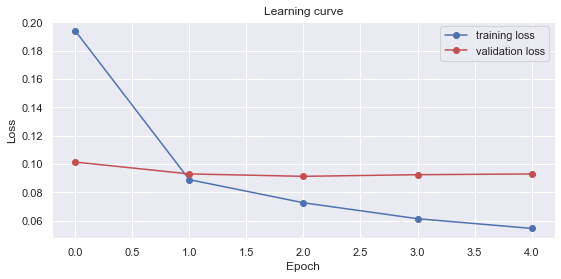

In [42]:
# Increase the plot size and font size
plt.rcParams["figure.figsize"] = (9, 4)

# Plot the learning curve.
plt.plot(train_losses, 'b-o', label="training loss")
plt.plot(val_losses, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
output_img_file = os.path.join(bert_plot_address, "loss.png")
plt.savefig(output_img_file)
plt.show()



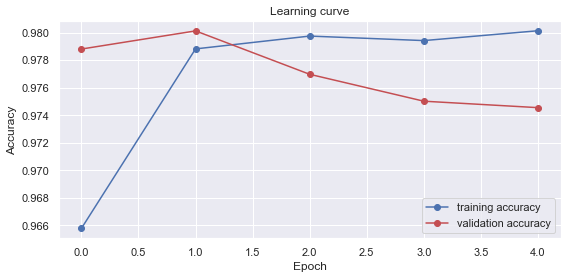

In [43]:
# Increase the plot size and font size
plt.rcParams["figure.figsize"] = (9, 4)

# Plot the learning curve.
plt.plot(train_accuracy, 'b-o', label="training accuracy")
plt.plot(val_accuracy, 'r-o', label="validation accuracy")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
output_img_file = os.path.join(bert_plot_address, "acc.png")
plt.savefig(output_img_file)
plt.show()

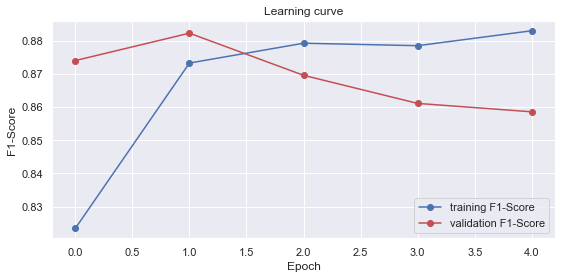

In [44]:
# Increase the plot size and font size
plt.rcParams["figure.figsize"] = (9, 4)

# Plot the learning curve.
plt.plot(train_f1, 'b-o', label="training F1-Score")
plt.plot(val_f1, 'r-o', label="validation F1-Score")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()
output_img_file = os.path.join(bert_plot_address, "f1.png")
plt.savefig(output_img_file)
plt.show()


In [45]:
model.eval();


In [46]:
test_data = TensorDataset(test_inputs,
                           test_masks, 
                           test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data,
                              sampler=test_sampler,
                              batch_size=batch_size)

In [47]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
y_true = []
y_pred = []

print("***** Running evaluation *****")
print("  Num examples = {}".format(len(test_inputs)))
print("  Batch size = {}".format(batch_size))
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    input_ids = input_ids.type(torch.LongTensor)
    input_mask = input_mask.type(torch.LongTensor)
    labels = labels.type(torch.LongTensor)

    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask,)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 
    
    # Get NER predict result
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    
    
    # Get NER true result
    labels = labels.to('cpu').numpy()
    
    
    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()
    
    for i,mask in enumerate(input_mask):
        temp_1 = []
        temp_2 = []
        
        for j, m in enumerate(mask):
            # Mark=0, meaning its a pad word, dont compare
            if m:
                if tag2name[labels[i][j]] != "X" and tag2name[labels[i][j]] != "[CLS]" and tag2name[labels[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1.append(tag2name[labels[i][j]])
                    temp_2.append(tag2name[logits[i][j]])
            else:
                break
        
            
        y_true.append(temp_1)
        y_pred.append(temp_2)

        

print("f1 score: %f"%(f1_score(y_true, y_pred)))
print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))

report = classification_report(y_true, y_pred,digits=4)

output_eval_file = os.path.join(bert_plot_address, "test_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    print("\n%s"%(report))
    print("f1 score: %f"%(f1_score(y_true, y_pred)))
    print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
    
    writer.write("f1 score:\n")
    writer.write(str(f1_score(y_true, y_pred)))
    writer.write("\n\nAccuracy score:\n")
    writer.write(str(accuracy_score(y_true, y_pred)))
    writer.write("\n\n")  
    writer.write(report)

***** Running evaluation *****
  Num examples = 9592
  Batch size = 32
f1 score: 0.823880
Accuracy score: 0.968290
***** Eval results *****

           precision    recall  f1-score   support

      tim     0.8706    0.8708    0.8707      4057
      org     0.6701    0.6559    0.6629      4124
      gpe     0.9497    0.9467    0.9482      3134
      geo     0.8398    0.9010    0.8693      7502
      per     0.7615    0.7878    0.7744      3393
      art     0.0000    0.0000    0.0000        94
      nat     0.3714    0.3250    0.3467        40
      eve     0.2830    0.2143    0.2439        70

micro avg     0.8152    0.8327    0.8239     22414
macro avg     0.8116    0.8327    0.8217     22414

f1 score: 0.823880
Accuracy score: 0.968290
